# TODO LIST

1. Train/val acc/loss 
2. Load model
3. Early stop
4. More experiments and findings
    - optimizer: ranger?
    - activation funciton?
    - data augmentation?
    - different nn structutr (vs no cnn?)

# Introduction

This juypter notebook will walk you through a basic example of training a CNN. We use the KMNIST as our dataset. 

Note: Before starting, run `# !rm -rf data` if you want to clean up the data directory.

To do a better research, follow the steps:

1. Quick and dirty code to make it work.
2. Refactor your code.
3. Write concise and precise jupyter notebook to organize your work and push it to Github.

One step at a time, and do your best at each step.

# 1. Data

## 1.1 Download the KNIST dataset

Note: Make sure to transform (i.e., preprocess) your data.

In [ ]:
# Download the KMNIST dataset from torchvision
import torchvision
from torchvision.transforms import transforms

# Do some transformation when we download the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

# Download the both the training and testing dataset
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Print out the downloaded data
print('-'*80)
print(train_dataset)
print('-'*80)
print(val_dataset)
print('-'*80)

: 

## 1.2 Dataloaders

Note: We need to specify batch size for dataloaders

In [2]:
import torch

# Need to specify batch size for dataloaders
batch_size = 16

# Create dataloaders for both training and valitation data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## 1.3 Visualizing the dataset

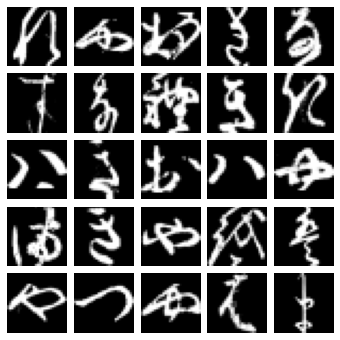

In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Create a grid plot
fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(
    
    # Similar to subplot(111)
    fig, 111,  
    
    # Create 5 by 5 grid of axes
    nrows_ncols=(5, 5),  
    
    # Pad between axes in inch.
    axes_pad=0.1,  
)

# Iterating over the grid returns the Axes.
for ax, (x, y) in zip(grid, train_dataset):
    
    # Unmornalize
    x = x / 2 + 0.5 
    
    # To numpy
    x = x.numpy()
    
    # Squeeze the image since there is only one channel
    x = x.squeeze()
    
    ax.imshow(x, cmap='gray')
    ax.set_axis_off()

plt.show()

# 2. Model

## 2.1 Architecture

In [4]:
# For building neural networks
import torch.nn as nn

# For activation functions
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.conv2 = nn.Conv2d(12, 24, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(24*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. Training

## 3.1 GPU support

In [6]:
# GPU configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3.2 Training function

In [7]:
def train_one_step(model, data, loss_func, optimizer):
    global device
    
    # Data
    x, y = data
    x, y = x.to(device), y.to(device)
    
    # Forward pass
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Optimize
    optimizer.step()

    correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
    loss = loss.cpu().item()
    
    return correct, loss

def train_one_epoch(model, dataloader, loss_func, optimizer):
    model.train()

    n_data = len(dataloader.dataset)
    n_batch = len(dataloader)

    total_loss = 0
    total_correct = 0
    
    for batch_idx, data in enumerate(dataloader):
        correct, loss = train_one_step(model, data, loss_func, optimizer)
        total_correct += correct
        total_loss += loss
    
    avg_loss = total_loss / n_batch
    acc = total_correct / n_data
    
    return acc, avg_loss

## 3.3 Validation function

In [8]:
def val_one_step(model, data, loss_func):
    
    # Data
    x, y = data
    x, y = x.to(device), y.to(device)
    
    # Forward pass
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    
    correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
    loss = loss.cpu().item()
    
    return correct, loss

def val_one_epoch(model, dataloader, loss_func):
    model.eval()

    n_data = len(dataloader.dataset)
    n_batch = len(dataloader)

    total_loss = 0
    total_correct = 0
    
    for batch_idx, data in enumerate(dataloader):
        with torch.no_grad():
            correct, loss = val_one_step(model, data, loss_func)
        total_correct += correct
        total_loss += loss
    
    avg_loss = total_loss / n_batch
    acc = total_correct / n_data
    
    return acc, avg_loss

## 3.3 Logging

In [9]:
def summary(epoch, n_epoch, train_acc, train_loss, val_acc, val_loss):
    print(f'Epoch [{epoch+1}/{n_epoch}] TrainAcc [{train_acc:.2%}] ValAcc [{val_acc:.2%}] TrainLoss [{train_loss:.2f}] ValLoss [{val_loss:.2f}]')

class Statistics:
    def __init__(self):
        self.train_acc_list = []
        self.val_acc_list = []
        self.train_loss_list = []
        self.val_loss_list = []
    def log_train_acc(self, acc):
        self.train_acc_list.append(acc)
    def log_val_acc(self, acc):
        self.val_acc_list.append(acc)
    def log_train_loss(self, loss):
        self.train_loss_list.append(loss)
    def log_val_loss(self, loss):
        self.val_loss_list.append(loss)
    def log(self, train_acc, train_loss, val_acc, val_loss):
        self.log_train_acc(train_acc)
        self.log_val_acc(val_acc)
        self.log_train_loss(train_loss)
        self.log_val_loss(val_loss)
    def plot(self):
        plt.subplot(221)
        plt.plot(stat.train_acc_list)
        plt.plot(stat.val_acc_list)

        plt.subplot(222)
        plt.plot(stat.train_loss_list)
        plt.plot(stat.val_loss_list)
        
        plt.show()

## 3.4 Model instance

In [11]:
# Create our model
model = ConvNet()

# See the model parameters
print(model)

# Push the model to GPU
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## 3.5 Loss function

In [ ]:
# Loss function
loss_func = nn.CrossEntropyLoss()

## 3.6 Optimizer

In [ ]:
# For optimizers
import torch.optim as optim

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

## 3.7. Start training

In [44]:
# Define the number of training epochs
n_epoch = 2

print('=== Started Training ===')

stat = Statistics()

for epoch in range(n_epoch):

    train_acc, train_loss = train_one_epoch(model, train_dataloader, loss_func, optimizer)
 
    val_acc, val_loss = val_one_epoch(model, val_dataloader, loss_func)
 
    stat.log(train_acc, train_loss, val_acc, val_loss)

    summary(epoch, n_epoch, train_acc, train_loss, val_acc, val_loss)

print('=== Finished Training ===')

=== Started Training ===
Epoch [1/2] TrainAcc [22.96%] ValAcc [26.61%] TrainLoss [2.28] ValLoss [2.25]
Epoch [2/2] TrainAcc [54.83%] ValAcc [50.59%] TrainLoss [1.68] ValLoss [1.53]
=== Finished Training ===


# 4. Review

## 4.1 Training v.s. Validation

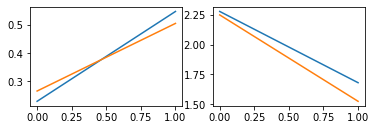

In [45]:
stat.plot()

## 4.2 Save the model

In [46]:
save_path = 'ckpt/kmnist-cnn.pth'

# Save model
torch.save(model.state_dict(), save_path)

# Load model
ckpt = torch.load(save_path)
model.load_state_dict(ckpt)

<All keys matched successfully>

## 4.3 Load the model